In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

%matplotlib inline
palette = sns.color_palette()

device = torch.device('cpu')

In [2]:
def generate_data(num_samples=5000, offset=0, alpha=2, beta=4):
    dist = torch.distributions.beta.Beta(alpha, beta)
    data = []
    for i in range(num_samples):
        data.append(dist.sample().item())
    return torch.tensor(data, requires_grad=False, device=device) + offset

tensor(0.0039) tensor(0.9310)
tensor(0.0870) tensor(0.9931)


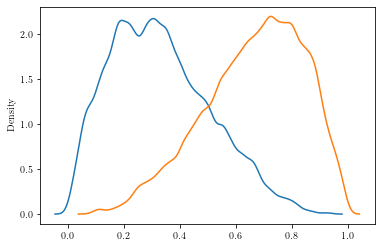

In [3]:
sample_offset1=torch.tensor([0], requires_grad=False, device=device)
sample_offset2=torch.tensor([0], requires_grad=False, device=device)
sample_data1 = generate_data(offset=sample_offset1, alpha=2, beta=4)
sample_data2 = generate_data(offset=sample_offset2, alpha=4, beta=2)

print(sample_data1.min(), sample_data1.max())
print(sample_data2.min(), sample_data2.max())

plt.figure()
sns.kdeplot(np.array(sample_data1.cpu()), bw_adjust=0.5, color=palette[0])
sns.kdeplot(np.array(sample_data2.cpu()), bw_adjust=0.5, color=palette[1])
plt.show()

tensor(-2.9996) tensor(-2.0933)
tensor(0.0757) tensor(0.9978)


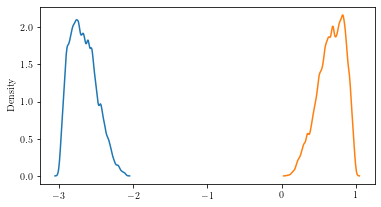

In [4]:
sample_offset1=torch.tensor([-3], requires_grad=False, device=device)
sample_offset2=torch.tensor([0], requires_grad=False, device=device)
sample_data1 = generate_data(offset=sample_offset1, alpha=2, beta=4)
sample_data2 = generate_data(offset=sample_offset2, alpha=4, beta=2)

plt.gca().set_aspect('equal', adjustable='box')

print(sample_data1.min(), sample_data1.max())
print(sample_data2.min(), sample_data2.max())

sns.kdeplot(np.array(sample_data1.cpu()), bw_adjust=0.5, color=palette[0])
sns.kdeplot(np.array(sample_data2.cpu()), bw_adjust=0.5, color=palette[1])

In [5]:
class Discriminator(nn.Sequential):
    def __init__(self, in_sizes=2, num_hidden=128, depth=2, spectral_norm=False):
        in_sizes = [in_sizes] + [num_hidden] * (depth - 1)        
        out_sizes = [num_hidden] * (depth - 1) + [1]
        if spectral_norm:
            layers = sum(
                [[nn.utils.spectral_norm(nn.Linear(in_size, out_size)), nn.LeakyReLU()] for in_size, out_size in zip(in_sizes, out_sizes)], 
                [])
        else:
            layers = sum(
                [[nn.Linear(in_size, out_size), nn.LeakyReLU()] for in_size, out_size in zip(in_sizes, out_sizes)], 
                [])
        layers = layers[:-1]
        super(Discriminator, self).__init__(*layers)


In [6]:
num_samples=5000
dim=1
num_hidden=32
depth=2

target_offset = torch.tensor([0], requires_grad=False, device=device)
offset = torch.tensor([-3.], requires_grad=True, device=device)

torch.random.manual_seed(1)
d_net = Discriminator(in_sizes=dim, num_hidden=num_hidden, depth=depth, spectral_norm=False)
d_net.to(device)

d_opt = torch.optim.SGD(d_net.parameters(), lr=0.01, momentum=0.9)
o_opt = torch.optim.SGD([offset], lr=0.01, momentum=0.9)

num_steps = 2001

for step in range(num_steps):
    label0 = torch.full((num_samples,), 0., device=device)
    label1 = torch.full((num_samples,), 1., device=device)
    target_data = generate_data(num_samples=num_samples, offset=target_offset,
                                alpha=4, beta=2).view(-1, 1)
    source_data = generate_data(num_samples=num_samples, offset=offset,
                                alpha=2, beta=4).view(-1, 1)
    
    # D
    d_net.zero_grad()
    d_source = d_net(source_data.detach()).view(-1)
    d_target = d_net(target_data).view(-1)
    
    loss_d_source = F.binary_cross_entropy_with_logits(d_source, label0)
    loss_d_target = F.binary_cross_entropy_with_logits(d_target, label1)
    
    (loss_d_source + loss_d_target).backward()
    d_opt.step()

    # G
    if offset.grad is not None:
        offset.grad.detach_()
        offset.grad.zero_()
    d_source = d_net(source_data).view(-1)
    loss_g_source = F.binary_cross_entropy_with_logits(d_source, label1)
    loss_g_source.backward()
    o_opt.step()
    
    if step % 20 == 0:
        print("step: %5d err_D_t: %.3f err_D_s: %.3f err_G: %.3f offset: %.3f" %
              (step, loss_d_target.item(), loss_d_source.item(), loss_g_source.item(), offset.item()))


step:     0 err_D_t: 0.761 err_D_s: 0.707 err_G: 0.747 offset: -2.999
step:    20 err_D_t: 0.044 err_D_s: 0.052 err_G: 3.151 offset: -1.767
step:    40 err_D_t: 1.620 err_D_s: 0.674 err_G: 1.036 offset: 1.239
step:    60 err_D_t: 0.660 err_D_s: 0.384 err_G: 1.278 offset: 2.154
step:    80 err_D_t: 0.348 err_D_s: 0.821 err_G: 0.697 offset: 0.497
step:   100 err_D_t: 0.497 err_D_s: 0.641 err_G: 0.837 offset: -0.210
step:   120 err_D_t: 0.820 err_D_s: 0.541 err_G: 0.937 offset: 0.613
step:   140 err_D_t: 0.629 err_D_s: 0.772 err_G: 0.625 offset: 0.330
step:   160 err_D_t: 0.726 err_D_s: 0.667 err_G: 0.728 offset: 0.286
step:   180 err_D_t: 0.688 err_D_s: 0.708 err_G: 0.688 offset: 0.360
step:   200 err_D_t: 0.699 err_D_s: 0.695 err_G: 0.697 offset: 0.327
step:   220 err_D_t: 0.698 err_D_s: 0.694 err_G: 0.700 offset: 0.330
step:   240 err_D_t: 0.696 err_D_s: 0.697 err_G: 0.697 offset: 0.336
step:   260 err_D_t: 0.697 err_D_s: 0.697 err_G: 0.697 offset: 0.336
step:   280 err_D_t: 0.694 err_

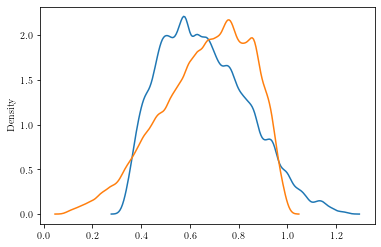

In [8]:
ada_data1 = generate_data(offset=offset, alpha=2, beta=4)
ada_data2 = generate_data(offset=target_offset, alpha=4, beta=2)

plt.figure()
sns.kdeplot(np.array(ada_data1.detach().cpu()), bw_adjust=0.5, color=palette[0])
sns.kdeplot(np.array(ada_data2.detach().cpu()), bw_adjust=0.5, color=palette[1])
plt.show()

In [9]:
print(ada_data1.min(), ada_data1.max())
print()
print(ada_data2.min(), ada_data2.max())

tensor(0.3260, grad_fn=<MinBackward1>) tensor(1.2464, grad_fn=<MaxBackward1>)

tensor(0.0962) tensor(0.9970)


In [10]:
num_samples=5000
dim=1
num_hidden=32
depth=2

target_offset = torch.tensor([0], requires_grad=False, device=device)
offset = torch.tensor([-3.], requires_grad=True, device=device)

torch.random.manual_seed(1)
d_net = Discriminator(in_sizes=dim, num_hidden=num_hidden, depth=depth, spectral_norm=False)
d_net.to(device)

d_opt = torch.optim.SGD(d_net.parameters(), lr=0.01, momentum=0.9)
o_opt = torch.optim.SGD([offset], lr=0.01, momentum=0.9)

num_steps = 2001

for step in range(num_steps):
    label0 = torch.full((num_samples,), 0., device=device)
    label1 = torch.full((num_samples,), 1., device=device)
    target_data = generate_data(num_samples=num_samples, offset=target_offset,
                                alpha=4, beta=2).view(-1, 1)
    source_data = generate_data(num_samples=num_samples, offset=offset,
                                alpha=2, beta=4).view(-1, 1)

    # D
    d_net.zero_grad()
    d_source = d_net(source_data.detach()).view(-1)
    d_target = d_net(target_data).view(-1)
    
    loss_d_source = F.binary_cross_entropy_with_logits(d_source, label0)
    loss_d_target = F.binary_cross_entropy_with_logits(d_target, label1)
    
    (loss_d_source + loss_d_target).backward()
    d_opt.step()

    # G
    if offset.grad is not None:
        offset.grad.detach_()
        offset.grad.zero_()
    d_source = d_net(source_data).view(-1)
    d_target = d_net(target_data).view(-1)
    d_dis = (d_source[:, None] - d_target[None, :]) ** 2
    dis_s_t = torch.mean(torch.min(d_dis, dim=1)[0])
    dis_t_s = torch.mean(torch.min(d_dis, dim=0)[0])
    (dis_s_t + dis_t_s).backward()
    o_opt.step()
    
    if step % 20 == 0:
        print("step: %5d err_D_t: %.3f err_D_s: %.3f dis_s_t: %.3f dis_t_s: %.3f offset: %.3f" %
              (step, loss_d_target.item(), loss_d_source.item(), dis_s_t.item(), dis_t_s.item(),
               offset.item()))


step:     0 err_D_t: 0.761 err_D_s: 0.707 dis_s_t: 0.000 dis_t_s: 0.000 offset: -3.000
step:    20 err_D_t: 0.743 err_D_s: 1.061 dis_s_t: 0.000 dis_t_s: 0.017 offset: 2.564
step:    40 err_D_t: 0.299 err_D_s: 0.429 dis_s_t: 1.783 dis_t_s: 0.426 offset: -0.824
step:    60 err_D_t: 0.876 err_D_s: 0.231 dis_s_t: 0.156 dis_t_s: 0.303 offset: 1.054
step:    80 err_D_t: 0.572 err_D_s: 0.657 dis_s_t: 0.002 dis_t_s: 0.000 offset: -0.093
step:   100 err_D_t: 0.540 err_D_s: 0.485 dis_s_t: 0.004 dis_t_s: 0.000 offset: 0.000
step:   120 err_D_t: 0.559 err_D_s: 0.535 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.095
step:   140 err_D_t: 0.538 err_D_s: 0.543 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.106
step:   160 err_D_t: 0.536 err_D_s: 0.532 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.107
step:   180 err_D_t: 0.535 err_D_s: 0.539 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.107
step:   200 err_D_t: 0.544 err_D_s: 0.531 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.106
step:   220 err_D_t: 0.534 err_D_s: 0.538 dis_s_t: 

step:  1920 err_D_t: 0.521 err_D_s: 0.526 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.101
step:  1940 err_D_t: 0.538 err_D_s: 0.527 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.101
step:  1960 err_D_t: 0.515 err_D_s: 0.520 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.101
step:  1980 err_D_t: 0.528 err_D_s: 0.526 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.101
step:  2000 err_D_t: 0.528 err_D_s: 0.508 dis_s_t: 0.000 dis_t_s: 0.000 offset: 0.100


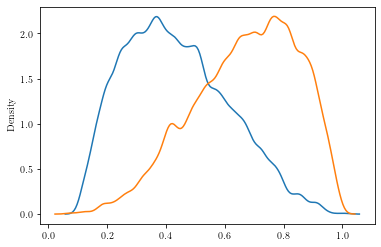

In [11]:
asa_data1 = generate_data(offset=offset, alpha=2, beta=4)
asa_data2 = generate_data(offset=target_offset, alpha=4, beta=2)

plt.figure()
sns.kdeplot(np.array(asa_data1.detach().cpu()), bw_adjust=0.5, color=palette[0])
sns.kdeplot(np.array(asa_data2.detach().cpu()), bw_adjust=0.5, color=palette[1])
plt.show()

In [12]:
print(asa_data1.min(), asa_data1.max())
print()
print(asa_data2.min(), asa_data2.max())

tensor(0.1067, grad_fn=<MinBackward1>) tensor(1.0092, grad_fn=<MaxBackward1>)

tensor(0.0719) tensor(0.9942)


In [13]:
def alignment_histplot(src_tensor, trg_tensor, title=None, legend=True, ylabel=True):

    src_array = src_tensor.numpy()
    trg_array = trg_tensor.numpy()

    mx = max(src_array.max(), trg_array.max())
    mn = min(src_array.min(), trg_array.min())
    d = max(mx - mn, 0.01)
    mn = mn - d * 0.12
    mx = mx + d * 0.12
    
    ax = sns.kdeplot(x=src_array, color=palette[0] + (0.75,), linewidth=6, fill=False, label='source')
    ax = sns.kdeplot(x=trg_array, color=palette[1] + (0.75,), linewidth=6, fill=False, label='target')    
    
    l1 = ax.lines[0]
    l2 = ax.lines[1]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]
    ax.fill_between(x1,y1, color=palette[0], alpha=0.25)
    ax.fill_between(x2,y2, color=palette[1], alpha=0.25)
    
    source_patch = matplotlib.patches.Patch(label='$p(x)$', edgecolor=palette[0] + (0.75,), 
                                            facecolor=palette[0] + (0.25,), linewidth=6)
    target_patch = matplotlib.patches.Patch(label='$q^\\theta(x)$', edgecolor=palette[1] + (0.75,), 
                                            facecolor=palette[1] + (0.25,), linewidth=6)    

    if ylabel:
        plt.ylabel('Density', fontsize=55, labelpad=10)
    else:
        plt.ylabel('', fontsize=75, labelpad=20)
    plt.xlabel('$x$', fontsize=55, labelpad=10)    
    plt.margins(y=0.45)    
    if legend:        
        plt.legend(handles=[source_patch, target_patch], fontsize=55, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=1, frameon=True, handlelength=1.25, columnspacing=1.0)
    
    plt.gca().set_xlim(mn, mx)
    plt.grid(linestyle='--', dashes=(12, 12))    
    ax = plt.gca()

    tick_labels = ax.xaxis.get_majorticklabels() + ax.yaxis.get_majorticklabels()

    for label in tick_labels:
        label.set_fontsize(55)

    ax.tick_params(axis='both', which='major', pad=15)

    if title is not None:
        plt.title(title, fontsize=42, y=1.02)

In [14]:
def w2_sq_dist(v1, v2):
    return torch.mean(torch.square(torch.sort(v1)[0] - torch.sort(v2)[0])).item()

def supp_sq_dist(v1, v2):
    dist_mat = torch.square(v1[:, None] - v2[None, :])
    dist_1_2 = torch.mean(torch.min(dist_mat, dim=1)[0])
    dist_2_1 = torch.mean(torch.min(dist_mat, dim=0)[0])
    
    return (dist_1_2 + dist_2_1).item()

init
W2_sq: 11.1147270 supp_sq: 15.2028332


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


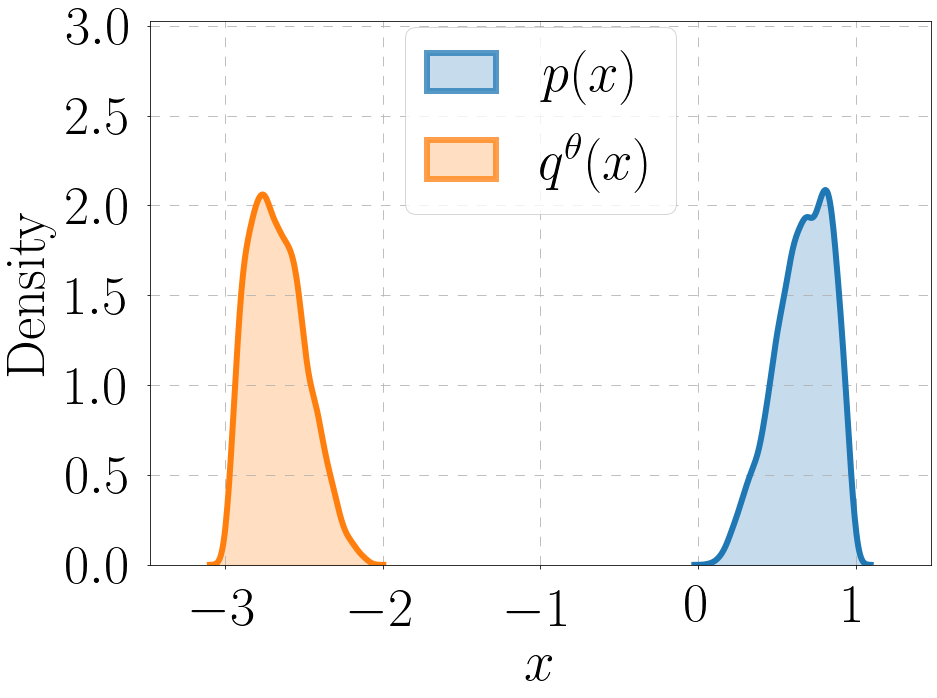

da
W2_sq: 0.0024852 supp_sq: 0.0007840


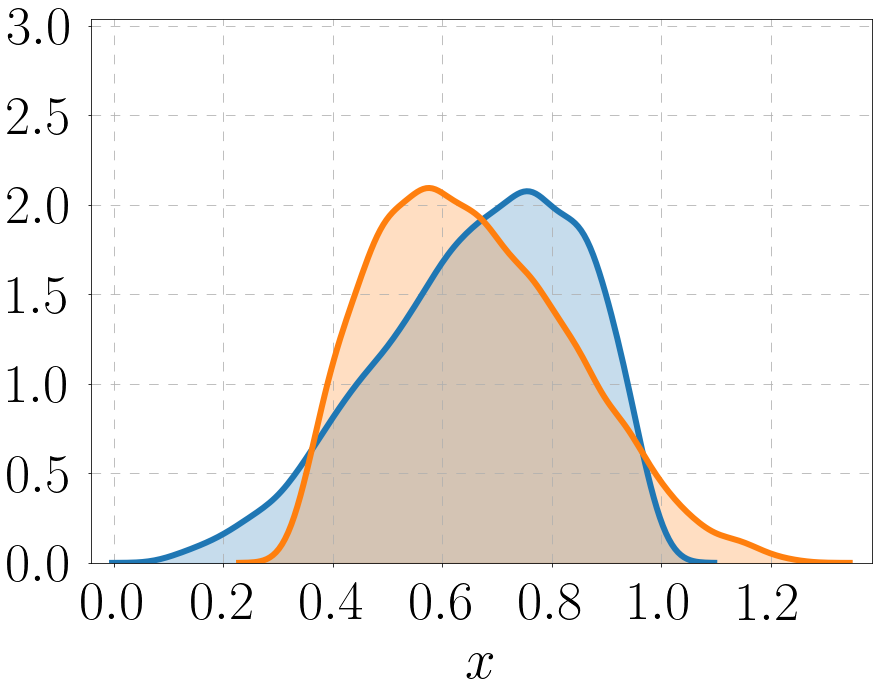

sa
W2_sq: 0.0575050 supp_sq: 0.0000028


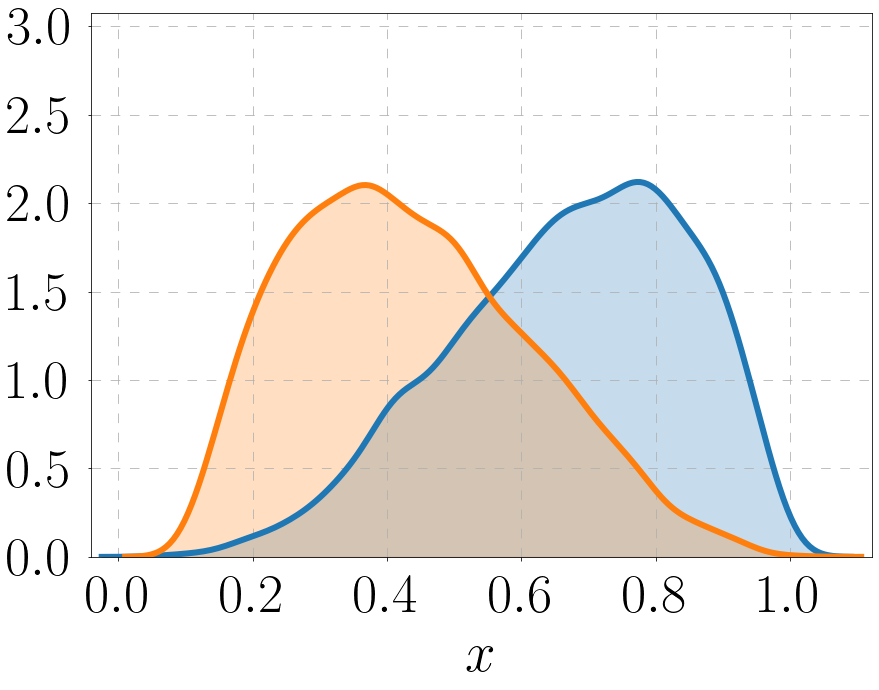

In [15]:
results = [
    ('init', sample_data2.detach(), sample_data1.detach()),
    ('da', ada_data2.detach(), ada_data1.detach()),
    ('sa', asa_data2.detach(), asa_data1.detach()),
]

for i, (name, t1, t2) in enumerate(results):
    print(name)
    print(f'W2_sq: {w2_sq_dist(t1, t2):.7f} supp_sq: {supp_sq_dist(t1, t2):.7f}')
    plt.figure(figsize=(14, 10.0))
    alignment_histplot(t1, t2, title=None, legend=i == 0, ylabel=i == 0)
    plt.savefig(f'./figures/betaplot_{name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()